# First CNN implementation

In [2]:
# Modules
import numpy as np
from matplotlib import pyplot
from skimage import color, data, exposure, feature, filters, io, morphology, segmentation, transform, util
import tensorflow as tf

import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import PIL
import os
from PIL import Image
import numpy as np
import sklearn
import keras
from PIL import Image
from numpy import asarray
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import random 
from keras.layers import LeakyReLU, concatenate, Dropout,BatchNormalization,Activation

In [3]:
import os
term_project_dir="/Users/pazma/Documents/BSE/spatial_data/term_project/"
os.chdir(term_project_dir)

In [4]:
# import custom-made functions
from helper_functions import *
from preprocess_and_stats import *

## Load the data

In [5]:
# get mask and sat paths from the train folder 
mask_train_files = sorted([f for f in os.listdir(term_project_dir + "data/land-train/") if re.match(r'.*mask\.png', f)])
sat_train_files = sorted([f for f in os.listdir(term_project_dir + "data/land-train/") if re.match(r'.*sat\.jpg', f)])
print(mask_train_files[:10])
print(sat_train_files[:10])

['100694_mask.png', '102122_mask.png', '10233_mask.png', '103665_mask.png', '103730_mask.png', '104113_mask.png', '10452_mask.png', '10901_mask.png', '111335_mask.png', '114433_mask.png']
['100694_sat.jpg', '102122_sat.jpg', '10233_sat.jpg', '103665_sat.jpg', '103730_sat.jpg', '104113_sat.jpg', '10452_sat.jpg', '10901_sat.jpg', '111335_sat.jpg', '114433_sat.jpg']


In [6]:
metadata_train=pd.DataFrame(mask_train_files,sat_train_files).reset_index()
metadata_train.columns=["sat", "mask"]

In [7]:
# class label dictionary
class_dict={"urban_land": [0, 255, 255],
           "agriculture_land": [255, 255, 0],
           "range_land": [255, 0, 255],
           "forest_land": [0, 255, 0],
           "water": [0, 0, 255],
           "barren_land": [255, 255, 255],
           "unknown": [0,0,0]}
class_dict.keys(), class_dict.values()

(dict_keys(['urban_land', 'agriculture_land', 'range_land', 'forest_land', 'water', 'barren_land', 'unknown']),
 dict_values([[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]))

In [8]:
# Get class names
class_names = list(class_dict.keys())
# Get class RGB values
class_rgb_values = list(class_dict.values())

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)


All dataset classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'range_land', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [9]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['urban_land', 'agriculture_land', 'range_land', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'range_land', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


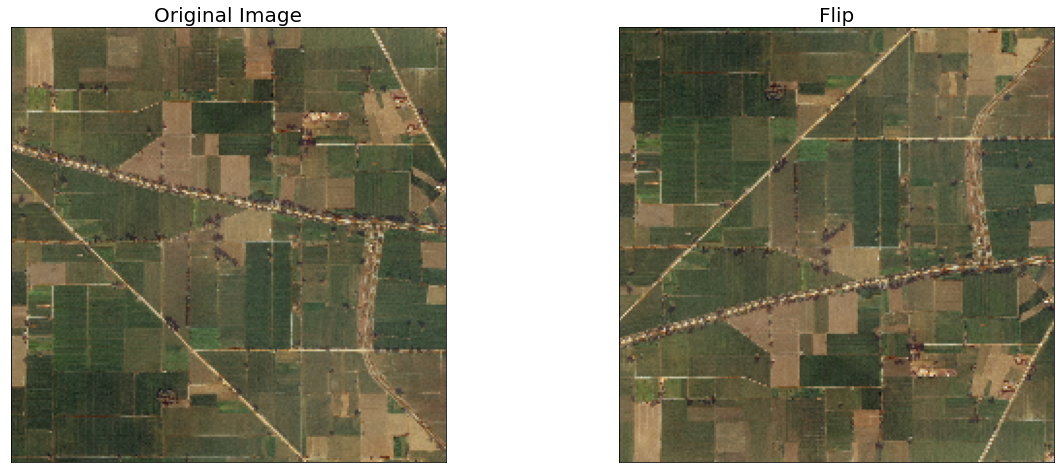

In [10]:
# show augmentation in action
im = load_img(term_project_dir + "data/land-train/"+'10233_sat.jpg',target_size=(224,224,3))
mask = load_img(term_project_dir + "data/land-train/"+'10233_mask.png',target_size=(224,224,3))


a,b = random_vertical_flip(im,mask, prob=1)
visualize(original_image = im, flip = a
         )

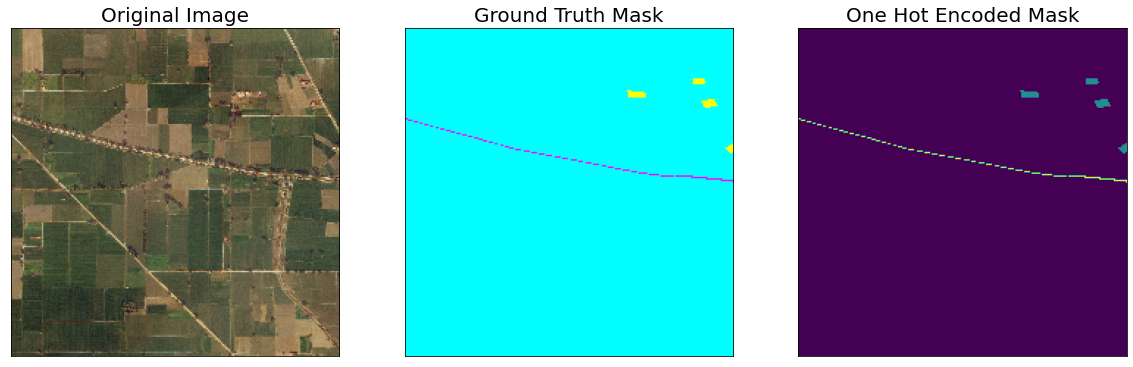

In [11]:
# show a random image with the ground truth and the one-hot encoded mask
BATCH_SIZE=32
dataset = land_cover_DataGenerator(term_project_dir + "data/land-train/", 
                                   class_rgb_values= select_class_rgb_values, batch_size= BATCH_SIZE)
random_idx = random.randint(0, len(dataset)-1)


visualize(
    original_image = im,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

## Definition od the UNet Model 

In [13]:
#% INITIALISES UNET MODEL

# Model structure
def init_unet(n_classes:int=7, input_size:tuple=(224, 224, 3)):
    # Input block
    inputs = keras.layers.Input(shape=input_size)
    # Convolutional block 1
    conv1 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv1 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = keras.layers.MaxPooling2D((2, 2))(conv1)
    # Convolutional block 2
    conv2 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = keras.layers.MaxPooling2D((2, 2))(conv2)
    # Convolutional block 3
    conv3 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = keras.layers.MaxPooling2D((2, 2))(conv3)
     # Convolutional block 4
    conv4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    # Convolutional block 5
    conv5 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    # De-convolutional block 1
    deco6 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    deco6 = keras.layers.concatenate([deco6, conv4])
    conv6 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(deco6)
    conv6 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    # De-convolutional block 2
    deco7 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    deco7 = keras.layers.concatenate([deco7, conv3])
    conv7 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(deco7)
    conv7 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    # De-convolutional block 3
    deco8 = keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    deco8 = keras.layers.concatenate([deco8, conv2])
    conv8 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(deco8)
    conv8 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    # De-convolutional block 4
    deco9 = keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    deco9 = keras.layers.concatenate([deco9, conv1], axis=3)
    conv9 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(deco9)
    conv9 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    # Ouput block
    outputs = keras.layers.Conv2D(n_classes, kernel_size=(1, 1), activation='sigmoid', padding='valid')(conv9)
    # Model
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model


## Generators and model compilation

In [14]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [15]:
# Compiles model
unet = init_unet()
opt = tf.keras.optimizers.Adam(epsilon=0.1)
unet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy', 'Recall', 'Precision'])

# Visualise model
unet.summary()


Metal device set to: Apple M1


2022-04-01 19:51:55.370068: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-01 19:51:55.370401: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

 conv2d_18 (Conv2D)             (None, 224, 224, 7)  119         ['conv2d_17[0][0]']              
                                                                                                  
Total params: 1,941,207
Trainable params: 1,941,207
Non-trainable params: 0
__________________________________________________________________________________________________


In [19]:
BATCH_SIZE = 32 
PATH_TRAIN =term_project_dir+'/data/land-train/'
PATH_VALIDATION = term_project_dir+'/data/land_valid_sat/'
LEARNING_RATE = 0.001
EPOCHS = 20
INPUT_SIZE = (224, 224, 3)
CLASS = select_class_rgb_values

train_generator = land_cover_DataGenerator(PATH_TRAIN,BATCH_SIZE,INPUT_SIZE, 
                                           class_rgb_values=CLASS, augmentation=True, augmentation_prob=0.1)
validation_generator = land_cover_DataGenerator(PATH_VALIDATION,BATCH_SIZE,INPUT_SIZE,
                                                class_rgb_values=CLASS, augmentation=True, augmentation_prob=0.1)

## Model Training 

In [ ]:
#%% ESTIMATES MODEL PARAMETERS

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='model/unet_{epoch:02d}_{val_categorical_accuracy:.4f}.h5', monitor='val_categorical_accuracy', save_best_only=True),
    keras.callbacks.BackupAndRestore(backup_dir='model')
]




# Estimates parameters

training = unet.fit(train_generator, 
    validation_data =validation_generator,
    batch_size = BATCH_SIZE,
    epochs = 30,
    verbose=1,
    callbacks=callbacks)

Epoch 1/30
22/22 [==============================] - 94s 4s/step - loss: 1.7875 - categorical_accuracy: 0.2899 - recall: 0.8001 - precision: 0.2261 - val_loss: 1.8155 - val_categorical_accuracy: 0.3904 - val_recall: 0.7833 - val_precision: 0.2337
Epoch 2/30
 3/22 [===>..........................] - ETA: 1:04 - loss: 1.7401 - categorical_accuracy: 0.3962 - recall: 0.8312 - precision: 0.2317

## Training results visualisation

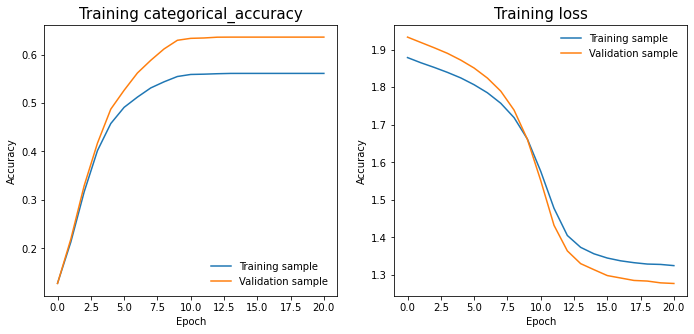

In [42]:
#%% DISPLAYS TRAINING HISTORY

def display_history(history:dict, stats:list=['categorical_accuracy', 'loss']) -> None:
    fig, axs = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 5))
    for ax, stat in zip(axs.ravel(), stats):
        ax.plot(training.history[stat])
        ax.plot(training.history[f'val_{stat}'])
        ax.set_title(f'Training {stat}', fontsize=15)
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend(['Training sample', 'Validation sample'], frameon=False)
    pyplot.tight_layout(pad=2.0)
    pyplot.show()

# Displays history
display_history(training.history)

# Saves model and history
keras.models.save_model(unet, 'model/unet_baseline.h5')
np.save('model/history_baseline.npy', training.history)

## Uploading the saved Model and summary

In [32]:
pwd

'/Users/sandravicariaaguilar/Desktop/Master/data-paper'

In [33]:
# save model
#unet.save(f'{os.getcwd()}/land_cover_model')

In [21]:
# load keras model and print summary
unet_model=keras.models.load_model("./models/unet_baseline.h5")

#unet_model.compile(loss="binary_focal_crossentropy",optimizer=opt,metrics=[iou])

## Evaluation of the Model 

### Train sample

In [28]:
train_scores=unet_model.evaluate(train_generator)

25/25 [==============================] - 112s 4s/step - loss: 1.3707 - categorical_accuracy: 0.5788 - recall: 0.9183 - precision: 0.2064


In [30]:
print("categorical crossentropy loss: ", train_scores[0])
print("categorical accuracy: ", train_scores[1])
print("Recall: ", train_scores[2])
print("Precision: ", train_scores[3])

categorical crossentropy loss:  1.3706997632980347
categorical accuracy:  0.5788490772247314
Recall:  0.9182941913604736
Precision:  0.2063964456319809


In [31]:
# show additional evaluation metrics (IoU)
unet_model.compile(loss="binary_focal_crossentropy",optimizer=opt,metrics=[iou])

In [32]:
score_iou=unet_model.evaluate(train_generator)
print("IoU: ", score_iou[0])

2022-04-01 20:12:58.145464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 119s 5s/step - loss: 0.2413 - iou: 0.1908
IoU:  0.2412666529417038


In [22]:
score = unet_model.evaluate(validation_generator, verbose=0)
print('val loss:', score[0])
print('val accuracy:', score[1])

2022-04-01 19:55:01.429437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


val loss: 0.0
val accuracy: 0.0


2022-04-01 19:55:58.179444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


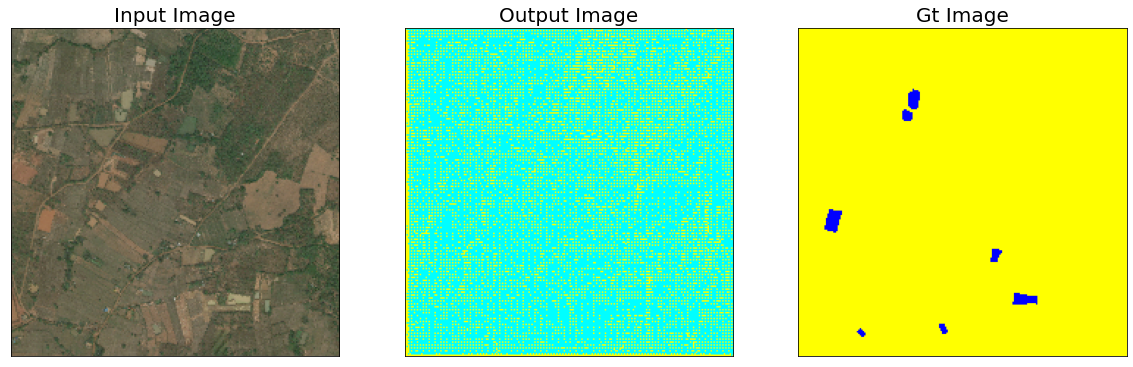

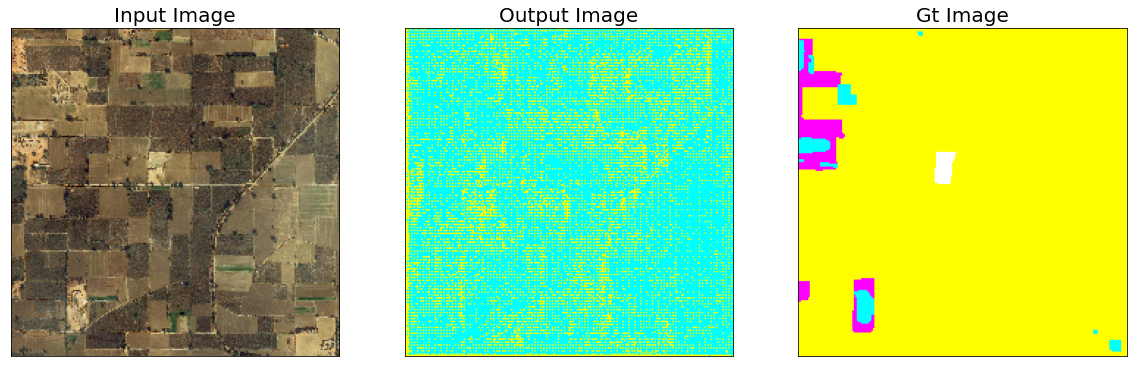

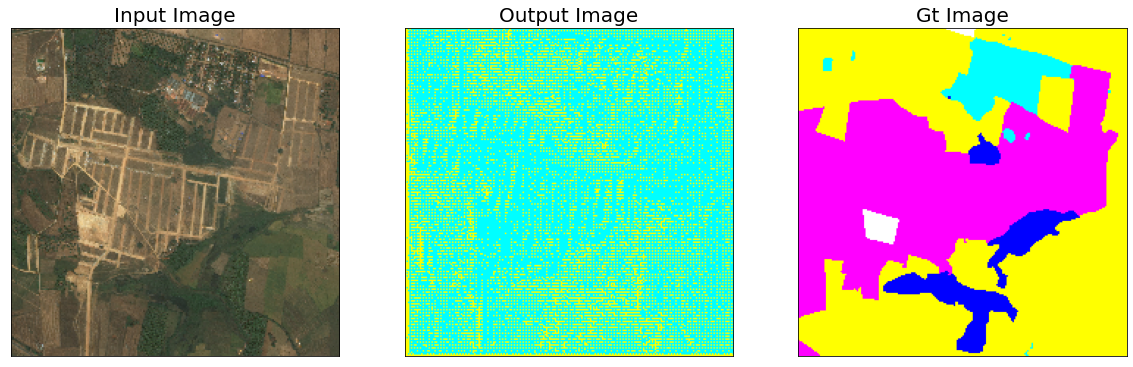

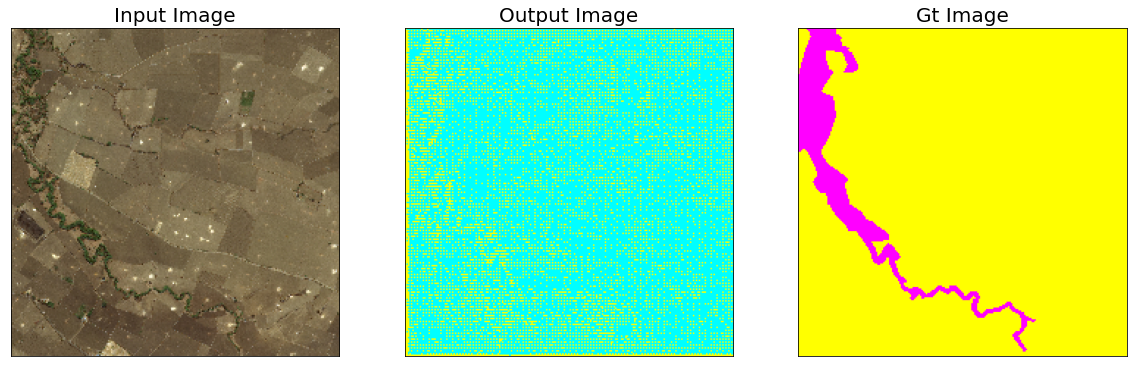

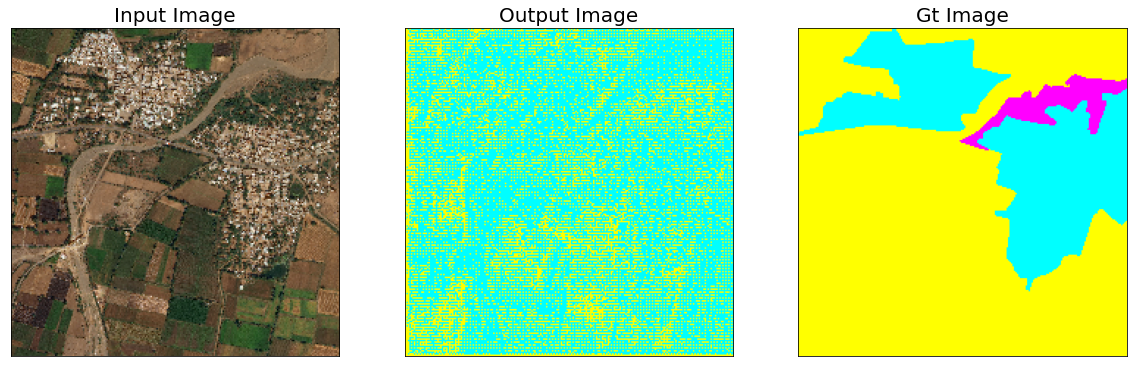

In [23]:
# load train images and their predictions
for i in np.random.choice(range(len(sat_train_files)), 5, replace=False):
    train_image=term_project_dir+'/data/land-train/'+sat_train_files[i]
    im = load_img(train_image,target_size=(224,224,3))
    mask=load_img(term_project_dir+'/data/land-train/'+ mask_train_files[i], target_size=(224,224,3))
    
    # predict
    im=np.expand_dims(im, axis=0)
    output=unet_model.predict(im)
    output=colour_code_segmentation(reverse_one_hot(output), select_class_rgb_values)

    # visualize prediction
    visualize(
        input_image=np.squeeze(im),
        output_image=np.squeeze(output),
        gt_image=mask     
            )

### Test sample

In [33]:
BATCH_SIZE = 32 
PATH_TEST =term_project_dir+'/data/land_test_sat/'
LEARNING_RATE = 0.001
INPUT_SIZE = (224, 224, 3)
CLASS = select_class_rgb_values

test_generator_augm = land_cover_DataGenerator(PATH_TRAIN,BATCH_SIZE,INPUT_SIZE, 
                                           class_rgb_values=CLASS, augmentation=True, augmentation_prob=0.5)

In [34]:
# show addtional evaluation metrics
unet_model.compile(loss=dice_loss,optimizer=opt,metrics=["Recall", "Precision", "categorical_accuracy", iou])

In [35]:
test_scores_unet=unet_model.evaluate(test_generator_augm)
print("Dice Loss: ", test_scores_unet[0])
print("Precision: ", test_scores_unet[1])
print("Recall: ", test_scores_unet[2])
print("Categorical Accuracy: ", test_scores_unet[3])
print("IoU: ", test_scores_unet[4])

2022-04-01 20:40:14.498256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 115s 4s/step - loss: 0.6796 - recall: 0.9183 - precision: 0.2064 - categorical_accuracy: 0.5788 - iou: 0.1908
Dice Loss:  0.6796144843101501
Precision:  0.918274462223053
Recall:  0.20640361309051514
Categorical Accuracy:  0.5788497924804688
IoU:  0.19079147279262543


In [24]:
import glob
test_images=glob.glob(term_project_dir+'/data/land_test_sat/*')

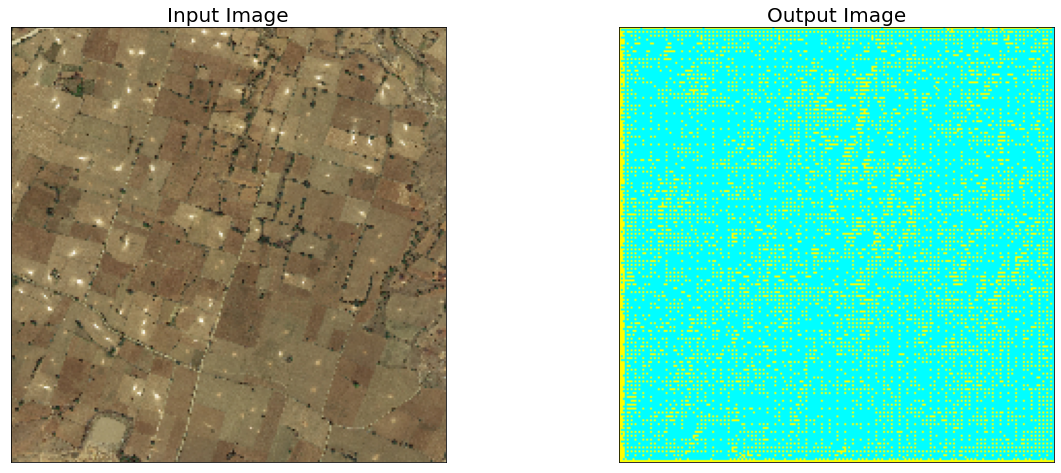

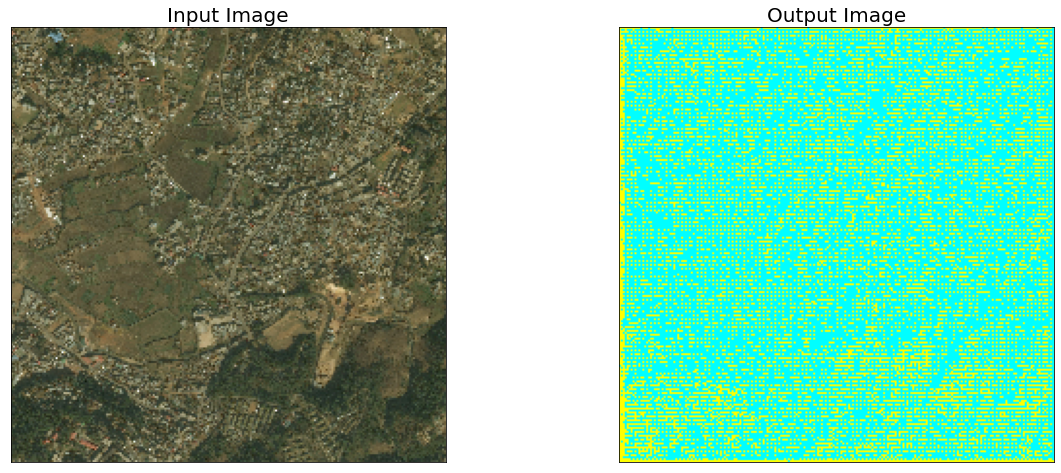

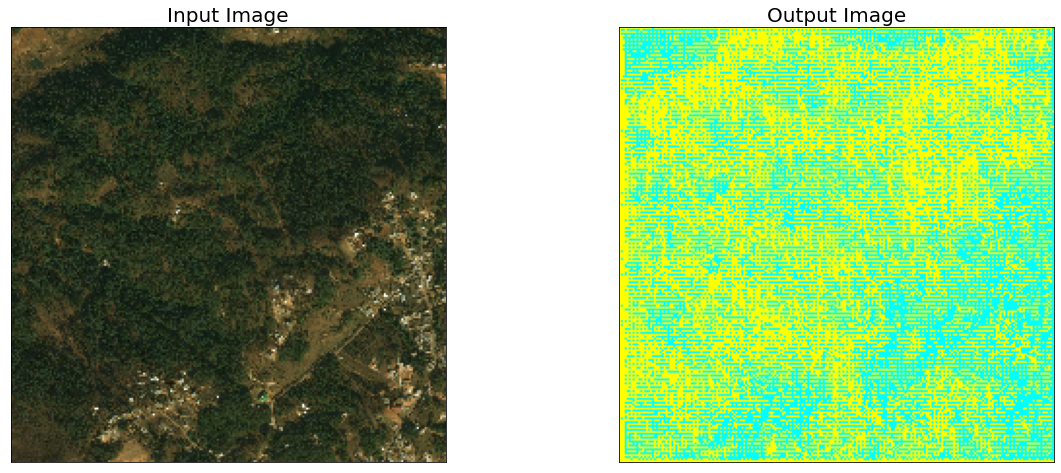

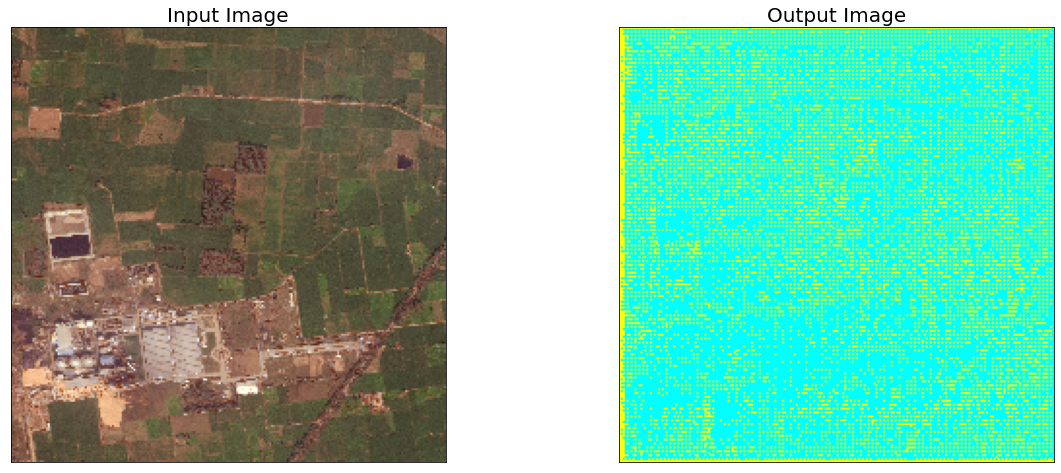

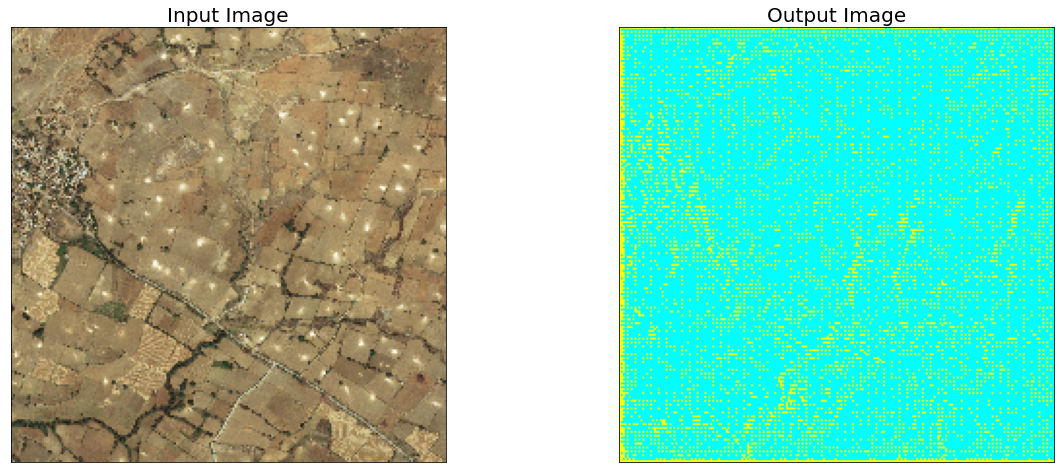

In [25]:
# load test images and their predictions
for i in np.random.choice(range(len(test_images)), 5, replace=False):
    im = load_img(test_images[i],target_size=(224,224,3))
    
    # predict
    im=np.expand_dims(im, axis=0)
    output=unet_model.predict(im)
    output=colour_code_segmentation(reverse_one_hot(output), select_class_rgb_values)

    # visualize prediction
    visualize(
        input_image=np.squeeze(im),
        output_image=np.squeeze(output) #,
        # gt_image=mask     
            )

2022-04-01 20:56:33.072991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


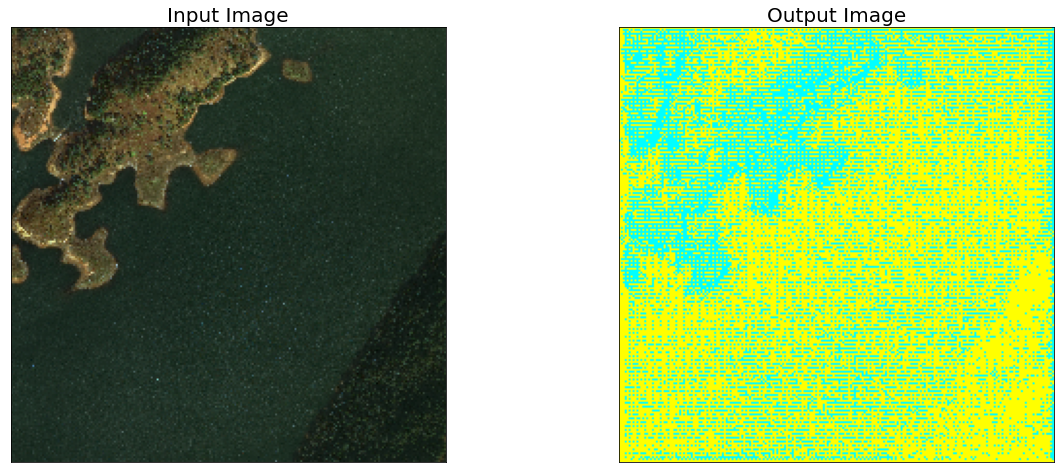

In [36]:
# show the prediction for the same image for the three models
image='/Users/pazma/Documents/BSE/spatial_data/term_project//data/land_test_sat/926551_sat.jpg'
im = load_img(image,target_size=(224,224,3))
    
# predict
im=np.expand_dims(im, axis=0)
output=unet_model.predict(im)
output=colour_code_segmentation(reverse_one_hot(output), select_class_rgb_values)

# visualize prediction
visualize(
    input_image=np.squeeze(im),
    output_image=np.squeeze(output) #,
    # gt_image=mask     
        )